In [29]:

import cv2

def resize_to_6x6(image):
    return cv2.resize(image, (6, 6), interpolation=cv2.INTER_AREA)
from tensorflow.keras.datasets import mnist
import numpy as np
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_small = resize_to_6x6(x_train[0])

print(f"Original shape: {x_train[0].shape}")  
print(f"New shape: {x_small.shape}")

Original shape: (28, 28)
New shape: (6, 6)


# DATA handling 

# *Convolutional operation 

In [30]:
def conv(matrix, kernel, stride=1, padding=0):
   
    matrix = np.array(matrix)
    kernel = np.array(kernel)
    
    m_rows, m_cols = matrix.shape
    k_rows, k_cols = kernel.shape
    
    out_rows = (m_rows - k_rows) // stride + 1
    out_cols = (m_cols - k_cols) // stride + 1
    
    output = np.zeros((out_rows, out_cols))
    for i in range(out_rows):
        for j in range(out_cols):
            output[i, j] = np.sum(matrix[i*stride:i*stride+k_rows, j*stride:j*stride+k_cols] * kernel)
    
    return output

# *Activation functions 

In [31]:
def relu(x):
    return np.maximum(x, 0)

def softmax(x):
    e = np.exp(x - np.max(x))  
    return e/ np.sum(e)
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# *Flatten - (n,m) into nXm data 

In [32]:
def flatten(x):
    return x.reshape(-1)

# *Max-pooling 

In [33]:
def max_pool(x, size=2, stride=2):
    h, w = x.shape
    out_h = (h - size) // stride + 1
    out_w = (w - size) // stride + 1
    output = np.zeros((out_h, out_w))

    for i in range(out_h):
        for j in range(out_w):
            region = x[i*stride:i*stride+size, j*stride:j*stride+size]
            output[i, j] = np.max(region)
    return output

# *Some other functions 

In [34]:
def dense(X, weights, bias):
    return np.dot(weights, X) + bias
def relu_deriv(x):
    return (x > 0).astype(float)
def cross_entropy(pred, label):
    return -np.log(pred[label] + 1e-9)
def softmax(x):
    x = x - np.max(x)  
    exp_x = np.exp(x)
    return exp_x / np.sum(exp_x)

# *Weight initialization 

In [35]:
def initialize_weights(input_shape, num_classes=2):
    w1 = np.random.randn(3, 3) * 0.1
    b1 = np.random.randn() * 0.1
    conv_out_size = (input_shape[0] - 3 + 1, input_shape[1] - 3 + 1)
    pool_out_size = (conv_out_size[0] // 2, conv_out_size[1] // 2)
    flattened_size = pool_out_size[0] * pool_out_size[1]

    w2 = np.random.randn(num_classes, flattened_size) * 0.1
    b2 = np.random.randn(num_classes) * 0.1

    return w1, b1, w2, b2

# *Forward propogation in CNN

In [36]:
def forprop(x, w1, b1, w2, b2):
    z1=conv(x,w1)+b1
    a1=relu(z1)
    p1=max_pool(a1)
    f=flatten(p1)
    z2=np.dot(w2,f.T)+b2
    a2=softmax(z2)
    return a2, z1, a1, p1, f, z2

def forward_pass(x, w1, b1, w2, b2):
    return forprop(x, w1, b1, w2, b2)

# *Back pooling 

In [37]:
def max_pool_backward(dout, input, size=2, stride=2):
    h, w = input.shape
    grad = np.zeros_like(input)
    for i in range(0, h - size + 1, stride):
        for j in range(0, w - size + 1, stride):
            region = input[i:i+size, j:j+size]
            idx = np.unravel_index(np.argmax(region), region.shape)
            grad[i + idx[0], j + idx[1]] = dout[i//stride, j//stride]
    return grad

# *Backpropogation in CNN 

In [38]:
def backprop(x, y, w1, b1, w2, b2, epochs=1, lr=0.1):
  
    a2, z1, a1, p1, f, z2 = forprop(x, w1, b1, w2, b2)
   
    dz2 = a2.copy()
    dz2[y] -= 1  
    
    dw2 = np.outer(dz2, f)
    db2 = dz2
    df = np.dot(w2.T, dz2)
    dp1 = df.reshape(p1.shape)
    da1 = max_pool_backward(dp1, a1)
    dz1 = da1 * relu_deriv(z1)
    dw1 = conv(x, dz1)
    db1 = np.sum(dz1)
    w2_new = w2 - lr * dw2
    b2_new = b2 - lr * db2
    w1_new = w1 - lr * dw1
    b1_new = b1 - lr * db1
    
    return w1_new, b1_new, w2_new, b2_new

# *Training in CNN 

In [39]:
def train_cnn(x, y, epochs=100, learning_rate=0.01):
   
    w1, b1, w2, b2 = initialize_weights(input_shape=x.shape,num_classes=10)

    losses = []
    
    print("Initial prediction:")
    initial_output, _, _, _, _, _ = forprop(x, w1, b1, w2, b2)
    print(f"Class probabilities: {initial_output}")
    print(f"Predicted class: {np.argmax(initial_output)}")
    print(f"Actual class: {y}")
    print("\nTraining...")
    
    for epoch in range(epochs):
        a2, z1, a1, p1, f, z2 = forprop(x, w1, b1, w2, b2)
        loss = cross_entropy(a2, y)
        losses.append(loss)
        w1, b1, w2, b2 = backprop(x, y, w1, b1, w2, b2, epochs=1, lr=learning_rate)
        
        if epoch % 10 == 0:
            pred_class = np.argmax(a2)
            print(f"Epoch {epoch+1:3d}, Loss: {loss:.4f}, Predicted: {pred_class}, Actual: {y}")
    
    return w1, b1, w2, b2, losses

# *Prediction  

In [40]:
def predict(x, w1, b1, w2, b2):
   
    a2, _, _, _, _, _ = forward_pass(x, w1, b1, w2, b2)
    return a2

# * Plotting and data fitting in CNN 

In [41]:
import matplotlib.pyplot as plt

Initial prediction:
Class probabilities: [0.1007042  0.07736725 0.09344726 0.11662001 0.09882764 0.12692434
 0.09954242 0.10153817 0.10865754 0.07637117]
Predicted class: 5
Actual class: 5

Training...
Epoch   1, Loss: 2.0642, Predicted: 5, Actual: 5
Epoch  11, Loss: 0.0052, Predicted: 5, Actual: 5
Epoch  21, Loss: 0.0023, Predicted: 5, Actual: 5
Epoch  31, Loss: 0.0014, Predicted: 5, Actual: 5
Epoch  41, Loss: 0.0010, Predicted: 5, Actual: 5
Epoch  51, Loss: 0.0008, Predicted: 5, Actual: 5
Epoch  61, Loss: 0.0006, Predicted: 5, Actual: 5
Epoch  71, Loss: 0.0005, Predicted: 5, Actual: 5
Epoch  81, Loss: 0.0005, Predicted: 5, Actual: 5
Epoch  91, Loss: 0.0004, Predicted: 5, Actual: 5

final report:


Probabilities: [2.87723457e-05 1.18883882e-05 9.19408580e-05 7.91323689e-05
 5.28012365e-05 9.99639847e-01 2.44791621e-05 1.87293376e-05
 3.84424010e-05 1.39670347e-05]
Predicted digit: 5


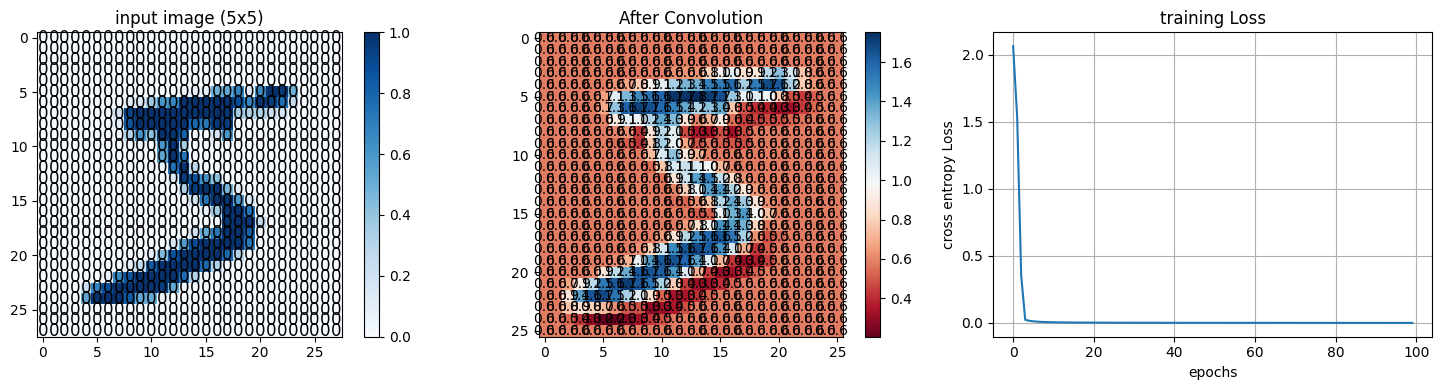

In [42]:
import matplotlib.pyplot as plt
import numpy as np

X = x_train[0]/255
y = y_train[0] 
w1, b1, w2, b2, losses = train_cnn(X, y, epochs=100, learning_rate=0.1)
final_output = predict(X, w1, b1, w2, b2)
predicted_class = np.argmax(final_output)

print("\nfinal report:\n\n")
print(f"Probabilities: {final_output}")
print(f"Predicted digit: {predicted_class}")

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(X, cmap='Blues', interpolation='nearest')
for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        plt.text(j, i, str(int(X[i, j])), ha='center', va='center', color='black', fontsize=12)
plt.title("input image (5x5)")
plt.colorbar()

plt.subplot(1, 3, 2)
conv_out = conv(X, w1) + b1
plt.imshow(conv_out, cmap='RdBu', interpolation='nearest')
for i in range(conv_out.shape[0]):
    for j in range(conv_out.shape[1]):
        plt.text(j, i, f'{conv_out[i, j]:.1f}', ha='center', va='center', color='black', fontsize=10)
plt.title("After Convolution")
plt.colorbar()

plt.subplot(1, 3, 3)
plt.plot(losses)
plt.title("training Loss")
plt.xlabel("epochs")
plt.ylabel("cross entropy Loss")
plt.grid(True)

plt.tight_layout()
plt.show()